# Exercises from Chap 6 


## Set-Up

In [242]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# import numpy as np

earthquakes = pd.read_csv('data/earthquakes.csv')

fb          = pd.read_csv('data/fb_stock_prices_2018.csv'
                , index_col = 'date'
                , parse_dates = True
                )

covid_df    = pd.read_csv('data/covid19_cases.csv'
                          ).assign(
                          date=lambda x: pd.to_datetime(x.dateRep, format='%d/%m/%Y')
                          ).set_index('date')


covid_df.info()
covid_df.head(10)
# fb.info()
# fb.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43718 entries, 2020-09-19 to 2020-03-21
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   dateRep                                                     43718 non-null  object 
 1   day                                                         43718 non-null  int64  
 2   month                                                       43718 non-null  int64  
 3   year                                                        43718 non-null  int64  
 4   cases                                                       43718 non-null  int64  
 5   deaths                                                      43718 non-null  int64  
 6   countriesAndTerritories                                     43718 non-null  object 
 7   geoId                                                       43529 no

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
date,,,,,,,,,,,,
2020-09-19,19/09/2020,19,9,2020,47,1,Afghanistan,AF,AFG,38041757.0,Asia,1.616645
2020-09-18,18/09/2020,18,9,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,1.535155
2020-09-17,17/09/2020,17,9,2020,17,0,Afghanistan,AF,AFG,38041757.0,Asia,1.653446
2020-09-16,16/09/2020,16,9,2020,40,10,Afghanistan,AF,AFG,38041757.0,Asia,1.708649
2020-09-15,15/09/2020,15,9,2020,99,6,Afghanistan,AF,AFG,38041757.0,Asia,1.627159
2020-09-14,14/09/2020,14,9,2020,75,0,Afghanistan,AF,AFG,38041757.0,Asia,1.456294
2020-09-13,13/09/2020,13,9,2020,35,0,Afghanistan,AF,AFG,38041757.0,Asia,1.309088
2020-09-12,12/09/2020,12,9,2020,34,0,Afghanistan,AF,AFG,38041757.0,Asia,1.224970
2020-09-11,11/09/2020,11,9,2020,28,0,Afghanistan,AF,AFG,38041757.0,Asia,1.164510


## Q1

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

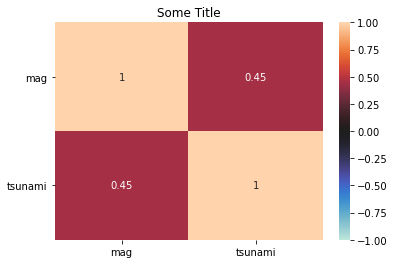

In [195]:
# earthquakes.query('magType == "mb"')
rows = earthquakes['magType'] == 'mb'

ax = sns.heatmap(
    earthquakes.loc[rows, ['mag', 'tsunami']]
    .corr()
    , annot=True, center=0, vmin=-1, vmax=1
    )
plt.title(f'Some Title')
plt.yticks(rotation=0)


# earthquakes[rows]

## Q2

           volume     close
0.25   17828394.0  157.9150
0.75   30313840.0  185.2700
iqr    12485446.0   27.3550
Q      18728169.0   41.0325
lower   -899775.0  116.8825
upper  49042009.0  226.3025


Text(0.5, 0.98, 'Facebook Volume Traded and Some Other Stuff for Ex2')

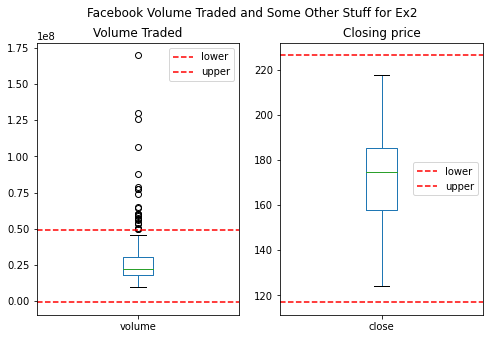

In [250]:
columns                     = ['volume', 'close']
titles                      = ['Volume Traded', 'Closing price']
subset_df                   = fb[columns]

quantiles                   = subset_df.quantile([0.25,0.75])
quantiles.loc['iqr',:]      = quantiles.loc[0.75,:] - quantiles.loc[0.25,:]
quantiles.loc['Q',:]        = 1.5 * (quantiles.loc[0.75,:] - quantiles.loc[0.25,:])
quantiles.loc['lower',:]    = quantiles.loc[0.25,:] - quantiles.loc['Q',:]  
quantiles.loc['upper',:]    = quantiles.loc[0.75,:] + quantiles.loc['Q',:]  
print(quantiles)

axes = subset_df.plot(
        kind = 'box'
        , subplots = True
        , figsize=(8, 5)
        )

for ax, col, title in zip(axes, columns, titles):
    for bound in ['lower', 'upper']:
        ax.axhline(
              quantiles.loc[bound,col]
            , color='r'
            , linestyle='--'
            , label=bound
            )
    ax.set_title(title)
    ax.legend() 

plt.suptitle('Facebook Volume Traded and Some Other Stuff for Ex2')

## Q3

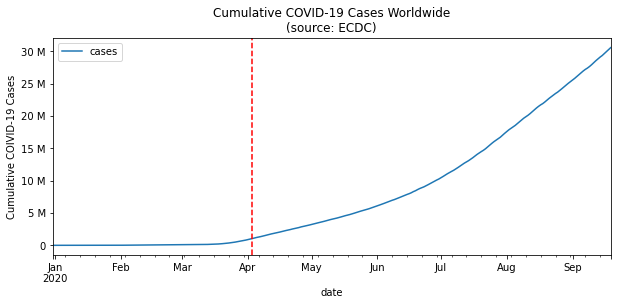

In [286]:
from matplotlib.ticker import EngFormatter

# Textbook version (creates a series)
# cumulative_cases_df = covid_df.groupby(pd.Grouper(freq = '1D')
#                     ).sum(
#                     )['cases'].cumsum(
#                     )

# # My version (creates a dataframe) 
cumulative_cases_df = covid_df.groupby(pd.Grouper(freq = '1D')
        ).agg({
        'cases': 'sum'    
        }).cumsum()
    
ax = cumulative_cases_df.plot(
          figsize = (10,4)
        , title = 'Cumulative COVID-19 Cases Worldwide\n(source: ECDC)'
        )


# over_1M = cumulative_cases_df[cumulative_cases_df['cases'] >= 1e6].index[0]
# ax.axvline(over_1M, linestyle='dashed', color='k', alpha=0.5, label=f"Reached 1M on {over_1M.strftime('%Y-%m-%d')}")


over_1M = cumulative_cases_df[cumulative_cases_df['cases'] >= 1e6].index[0]
ax.axvline(
        over_1M
        , color='r'
        , linestyle='--'
        , label=f'Over 1M ({over_1M})'
        )

plt.ylabel('Cumulative COIVID-19 Cases')
ax.yaxis.set_major_formatter(EngFormatter())


# print(KT_cumulative_cases_df.info())
# print(cumulative_cases_df.info())

## Q4

## Q5

## Q6

## Q7

## Q8

## Q9

## Q10